## AI-Driven System for Oil Spill Identification and Monitoring

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob

# Image configuration
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
IMAGE_TYPE = 'RGB'  # Change to 'SAR' for SAR images

# Dataset root
DATASET_PATH = "DataSet"
TRAIN_IMG = os.path.join(DATASET_PATH, "train/images")
TRAIN_MASK = os.path.join(DATASET_PATH, "train/masks")
VAL_IMG = os.path.join(DATASET_PATH, "val/images")
VAL_MASK = os.path.join(DATASET_PATH, "val/masks")
TEST_IMG = os.path.join(DATASET_PATH, "test/images")
TEST_MASK = os.path.join(DATASET_PATH, "test/masks")  # if available


### 1.2 Sanity Check

In [18]:
def check_pairs(image_dir, mask_dir):
    images = sorted(os.listdir(image_dir))
    masks = sorted(os.listdir(mask_dir))
    assert len(images) == len(masks), f"❌ Mismatch: {len(images)} images vs {len(masks)} masks"
    
    mismatches = []
    for i, (img, msk) in enumerate(zip(images, masks)):
        if os.path.splitext(img)[0] != os.path.splitext(msk)[0]:
            mismatches.append((img, msk))
    
    if mismatches:
        for img, msk in mismatches:
            print(f"⚠️ Name mismatch: {img} vs {msk}")
    else:
        print(f"✅ Everything is OK in {image_dir} & {mask_dir}")


check_pairs(TRAIN_IMG, TRAIN_MASK)
check_pairs(VAL_IMG, VAL_MASK)
check_pairs(TEST_IMG, TEST_MASK)

✅ Everything is OK in DataSet\train/images & DataSet\train/masks
✅ Everything is OK in DataSet\val/images & DataSet\val/masks
✅ Everything is OK in DataSet\test/images & DataSet\test/masks


In [19]:
from scipy.ndimage import uniform_filter

def lee_filter(img, window_size=5):
    """
    Lee speckle filter for SAR images.
    img : 2D numpy array (SAR image)
    window_size : size of local filter window
    """
    img = img.astype(np.float32)

    # Local mean & variance
    img_mean = uniform_filter(img, window_size)
    img_sqr_mean = uniform_filter(img**2, window_size)
    img_variance = img_sqr_mean - img_mean**2

    # Noise variance (whole image variance)
    overall_variance = np.var(img)

    # Lee filter formula
    weights = img_variance / (img_variance + overall_variance + 1e-10)
    lee_img = img_mean + weights * (img - img_mean)

    return lee_img


def preprocess_sar(image, method='lee'):
    """Preprocess SAR image: speckle noise reduction + normalization"""
    
    # 1. Speckle noise reduction
    if method == 'lee':
        image = lee_filter(image, window_size=5)
    
    # 2. Log scaling + z-score normalization
    image = np.log(image + 1e-10)
    image = (image - image.mean()) / (image.std() + 1e-10)
    
    # 3. Scale to [0,1]
    image = (image - image.min()) / (image.max() - image.min() + 1e-10)
    
    return image.astype(np.float32)


def preprocess_rgb(image):
    """Normalize RGB image to [0,1]"""
    return image.astype(np.float32) / 255.0


print("Preprocessing functions ready!")


Preprocessing functions ready!


In [21]:
def load_image(image_path, image_type='RGB'):
    """Load and preprocess image"""
    if image_type == 'SAR':
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = preprocess_sar(img.astype(np.float32)/255.0)
        img = np.stack([img, img, img], axis=-1)
    else:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = preprocess_rgb(img)
    return img

def load_mask(mask_path):
    """Load and preprocess mask"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.float32)
    return mask

print("Image preprocessing functions ready!")

Image preprocessing functions ready!


In [22]:
def geometric_augmentation(image, mask):
    """Apply geometric augmentations"""
    # Random horizontal flip
    if np.random.random() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    
    # Random vertical flip
    if np.random.random() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    
    # Random rotation (90, 180, 270 degrees)
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    mask = np.rot90(mask, k)
    
    return image, mask

def photometric_augmentation(image, image_type='RGB'):
    """Apply photometric augmentations"""
    if image_type == 'RGB':
        # Brightness variation
        if np.random.random() > 0.5:
            brightness = np.random.uniform(0.8, 1.2)
            image = np.clip(image * brightness, 0, 1)
        
        # Contrast variation
        if np.random.random() > 0.5:
            contrast = np.random.uniform(0.8, 1.2)
            image = np.clip((image - 0.5) * contrast + 0.5, 0, 1)
        
        # Random noise injection
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.02, image.shape)
            image = np.clip(image + noise, 0, 1)
    
    return image

print("Data augmentation functions ready!")

Data augmentation functions ready!


In [23]:
def load_dataset(dataset_path, split, apply_augmentation=False):
    """Load complete dataset for a given split"""
    images_path = os.path.join(dataset_path, split, "images")
    masks_path = os.path.join(dataset_path, split, "masks")
    
    image_files = sorted([f for f in os.listdir(images_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(masks_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"Loading {len(image_files)} samples from {split} set...")
    
    images, masks = [], []
    
    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)
        
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            continue
        
        image = load_image(img_path, IMAGE_TYPE)
        mask = load_mask(mask_path)
        
        if apply_augmentation:
            image, mask = geometric_augmentation(image, mask)
            image = photometric_augmentation(image, IMAGE_TYPE)
        
        images.append(image)
        masks.append(mask)
        
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{len(image_files)} samples")
    
    return np.array(images), np.array(masks)

# Load the data
print("Loading training data...")
X_train, y_train = load_dataset(DATASET_PATH, "train", apply_augmentation=True)

print("\nLoading validation data...")
X_val, y_val = load_dataset(DATASET_PATH, "val", apply_augmentation=False)

print("\nLoading test data...")
X_test, y_test = load_dataset(DATASET_PATH, "test", apply_augmentation=False)

print(f"\nData shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Loading training data...
Loading 811 samples from train set...
Processed 50/811 samples
Processed 100/811 samples
Processed 150/811 samples
Processed 200/811 samples
Processed 250/811 samples
Processed 300/811 samples
Processed 350/811 samples
Processed 400/811 samples
Processed 450/811 samples
Processed 500/811 samples
Processed 550/811 samples
Processed 600/811 samples
Processed 650/811 samples
Processed 700/811 samples
Processed 750/811 samples
Processed 800/811 samples

Loading validation data...
Loading 203 samples from val set...
Processed 50/203 samples
Processed 100/203 samples
Processed 150/203 samples
Processed 200/203 samples

Loading test data...
Loading 254 samples from test set...
Processed 50/254 samples
Processed 100/254 samples
Processed 150/254 samples
Processed 200/254 samples
Processed 250/254 samples

Data shapes:
X_train: (811, 256, 256, 3), y_train: (811, 256, 256)
X_val: (203, 256, 256, 3), y_val: (203, 256, 256)
X_test: (254, 256, 256, 3), y_test: (254, 256, 25

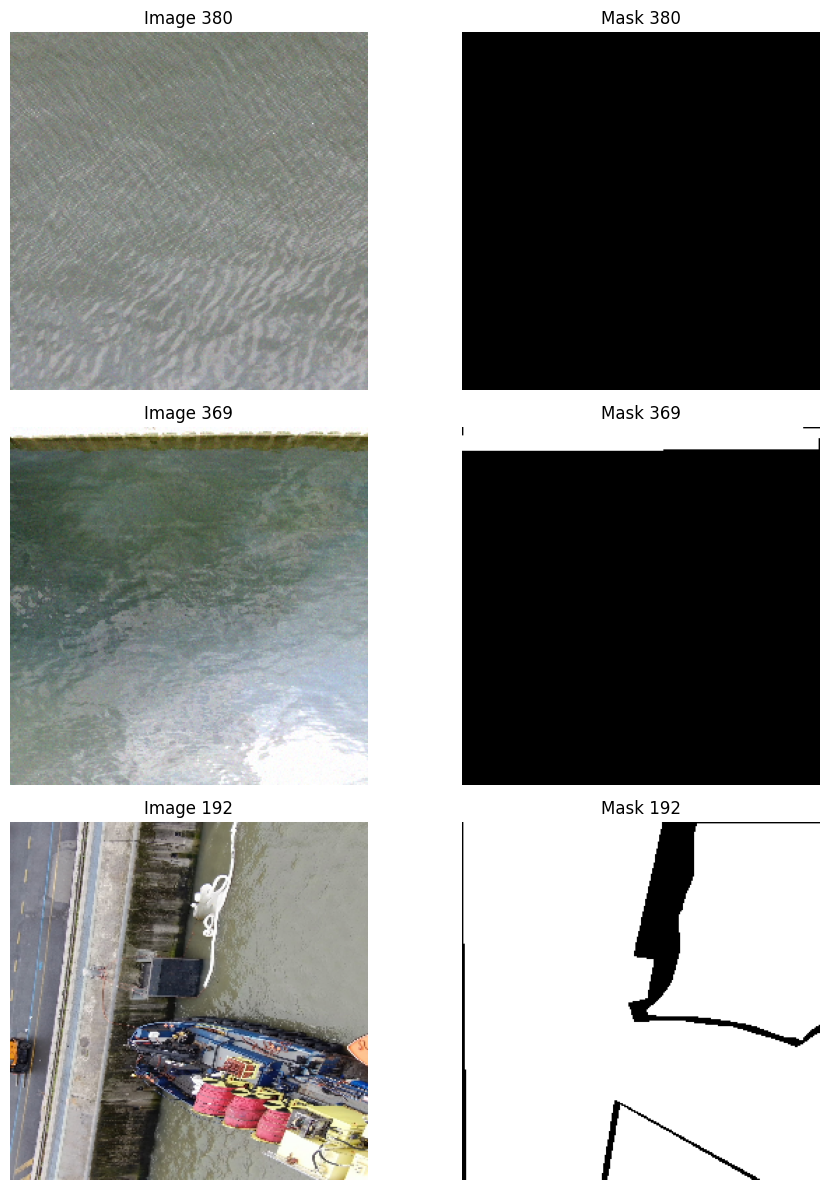

In [24]:
def visualize_samples(images, masks, num_samples=3):
    """Visualize preprocessed samples"""
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title(f'Image {idx}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[idx], cmap='gray')
        axes[i, 1].set_title(f'Mask {idx}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(X_train, y_train, 3)

In [25]:
print("\n" + "="*50)
print("PREPROCESSING SUMMARY")
print("="*50)
print(f"✓ Dataset: {DATASET_PATH}")
print(f"✓ Image type: {IMAGE_TYPE}")
print(f"✓ Image size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Validation samples: {len(X_val)}")
print(f"✓ Test samples: {len(X_test)}")
print("\nFeatures:")
print("✓ SAR speckle noise reduction (Lee filter)")
print("✓ SAR log-scaling + z-score normalization")
print("✓ RGB normalization to [0,1]")
print("✓ Binary masks (oil=1, background=0)")
print("✓ Geometric augmentation (flips, rotations)")
print("✓ Photometric augmentation (brightness, contrast, noise)")
print("✓ SAR-specific augmentation (speckle simulation)")
print("\nData ready for model training!")
print("="*50)


PREPROCESSING SUMMARY
✓ Dataset: DataSet
✓ Image type: RGB
✓ Image size: 256x256x3
✓ Training samples: 811
✓ Validation samples: 203
✓ Test samples: 254

Features:
✓ SAR speckle noise reduction (Lee filter)
✓ SAR log-scaling + z-score normalization
✓ RGB normalization to [0,1]
✓ Binary masks (oil=1, background=0)
✓ Geometric augmentation (flips, rotations)
✓ Photometric augmentation (brightness, contrast, noise)
✓ SAR-specific augmentation (speckle simulation)

Data ready for model training!


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,SeparableConv2D, concatenate, Dropout, BatchNormalization,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [33]:
# def build_unet(input_shape=(256, 256, 3), dropout_rate=0.1):
#     inputs = Input(input_shape)

#     # Encoder
#     c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
#     c1 = BatchNormalization()(c1)
#     c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
#     c1 = BatchNormalization()(c1)
#     p1 = MaxPooling2D((2,2))(c1)
#     p1 = Dropout(dropout_rate)(p1)

#     c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
#     c2 = BatchNormalization()(c2)
#     c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
#     c2 = BatchNormalization()(c2)
#     p2 = MaxPooling2D((2,2))(c2)
#     p2 = Dropout(dropout_rate)(p2)

#     c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
#     c3 = BatchNormalization()(c3)
#     c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
#     c3 = BatchNormalization()(c3)
#     p3 = MaxPooling2D((2,2))(c3)
#     p3 = Dropout(dropout_rate)(p3)

#     c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
#     c4 = BatchNormalization()(c4)
#     c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)
#     c4 = BatchNormalization()(c4)
#     p4 = MaxPooling2D((2,2))(c4)
#     p4 = Dropout(dropout_rate)(p4)

#     # Bottleneck
#     c5 = Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
#     c5 = BatchNormalization()(c5)
#     c5 = Conv2D(1024, (3,3), activation='relu', padding='same')(c5)
#     c5 = BatchNormalization()(c5)

#     # Decoder
#     u6 = UpSampling2D((2,2))(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv2D(512, (3,3), activation='relu', padding='same')(u6)
#     c6 = BatchNormalization()(c6)
#     c6 = Conv2D(512, (3,3), activation='relu', padding='same')(c6)
#     c6 = BatchNormalization()(c6)

#     u7 = UpSampling2D((2,2))(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(256, (3,3), activation='relu', padding='same')(u7)
#     c7 = BatchNormalization()(c7)
#     c7 = Conv2D(256, (3,3), activation='relu', padding='same')(c7)
#     c7 = BatchNormalization()(c7)

#     u8 = UpSampling2D((2,2))(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(128, (3,3), activation='relu', padding='same')(u8)
#     c8 = BatchNormalization()(c8)
#     c8 = Conv2D(128, (3,3), activation='relu', padding='same')(c8)
#     c8 = BatchNormalization()(c8)

#     u9 = UpSampling2D((2,2))(c8)
#     u9 = concatenate([u9, c1])
#     c9 = Conv2D(64, (3,3), activation='relu', padding='same')(u9)
#     c9 = BatchNormalization()(c9)
#     c9 = Conv2D(64, (3,3), activation='relu', padding='same')(c9)
#     c9 = BatchNormalization()(c9)

#     outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

# model = build_unet()
# model.summary()



from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model

def build_medium_unet(input_shape=(256, 256, 3), dropout_rate=0.1):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout_rate)(p1)

    c2 = Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    c3 = Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(128, (3,3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)
    p3 = Dropout(dropout_rate)(p3)

    # Bottleneck
    c4 = Conv2D(256, (3,3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(256, (3,3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u5 = UpSampling2D((2,2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3,3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(128, (3,3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = UpSampling2D((2,2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3,3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(64, (3,3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2,2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3,3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(32, (3,3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_medium_unet()
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 32  128        ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

In [34]:
from tensorflow.keras.metrics import BinaryAccuracy

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# 1) Expand masks
y_train = np.expand_dims(y_train, -1).astype(np.float32)
y_val = np.expand_dims(y_val, -1).astype(np.float32)

model.compile(optimizer=Adam(1e-4), loss=dice_loss, metrics=[dice_coef, BinaryAccuracy(name="accuracy"
                                                                                       )])


In [35]:
# callbacks = [
#     EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
#     ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, verbose=1),
#     ModelCheckpoint("unet_oilspill.keras",  # save in new format
#                     save_best_only=True,
#                     verbose=1)
# ]
# 3) Callbacks (monitor dice)
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=12, mode='max', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("Unet_OilSpill.keras", monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1)
]


In [37]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 0.1865 - dice_coef: 0.8142 - accuracy: 0.8018
Epoch 1: val_dice_coef improved from -inf to 0.66307, saving model to Unet_OilSpill.keras
102/102 [==============================] - 616s 6s/step - loss: 0.1865 - dice_coef: 0.8142 - accuracy: 0.8018 - val_loss: 0.3404 - val_dice_coef: 0.6631 - val_accuracy: 0.5880 - lr: 1.0000e-04
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.1552 - dice_coef: 0.8447 - accuracy: 0.8207
Epoch 2: val_dice_coef improved from 0.66307 to 0.71914, saving model to Unet_OilSpill.keras
102/102 [==============================] - 622s 6s/step - loss: 0.1552 - dice_coef: 0.8447 - accuracy: 0.8207 - val_loss: 0.2850 - val_dice_coef: 0.7191 - val_accuracy: 0.6004 - lr: 1.0000e-04
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.1445 - dice_coef: 0.8552 - accuracy: 0.8309
Epoch 3: val_dice_coef improved from 0.71914 to 0.72620, saving model to Unet_OilSp